In [231]:
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        """
        在Python中,以下划线_开头的属性名有特殊含义
        单下划线前缀 (_prev, _op, _backward): 表示这些是内部实现细节,不应该被外部代码直接访问或修改。这是Python的约定，提示这些属性是"私有的"。
        无下划线 (data, grad, label): 表示这些是公共接口，外部代码可以安全地访问和使用。
        在你的代码中：
        data, grad, label - 用户会直接使用的属性
        _prev, _op, _backward - 计算图的内部实现，用户不需要直接操作
        这种命名约定帮助区分哪些是API的一部分,哪些是内部实现。
        """

        self.data=data    #data: 存储节点的值
        self.grad=0.0      #grad: 存储梯度
        self._prev=set(_children) #_prev: 存储节点的父节点
        self._op=_op       #_op: 存储节点的操作符
        self.label=label   #label: 存储节点的标签
        self._backward=lambda:None #_backward: 存储梯度计算的函数


    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data,(self,other),"+")

        def _backward():        # 没有 def 就会立即执行梯度计算。
            self.grad+=out.grad
            other.grad+=out.grad
        out._backward=_backward # def 把梯度计算延迟到调用 backward() 时执行
        return out              #确保梯度计算的正确顺序。

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data,(self,other),"*")

        def _backward():
            self.grad+=out.grad*other.data
            other.grad+=out.grad*self.data
        out._backward=_backward
        return out
    
    def __pow__(self,other):
        """举例：
            乘法: a * b - 两个都是变量，都需要梯度
            a = Value(2.0)
            b = Value(3.0)
            c = a * b → 父节点是 (a, b)
            幂运算: a ** 2 - 只有底数是变量，指数是常数
            a = Value(2.0)
            c = a ** 2 → 父节点只有 (a,),因为指数2不需要梯度
            """
        assert isinstance(other, (int, float))
        out=Value(self.data**other,(self,),f"**{other}")
        def _backward():
            self.grad+=out.grad*other*self.data**(other-1)
        out._backward=_backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out


    def backward(self):
        """
        反向传播方法：从当前节点开始，自动计算整个计算图的梯度
        
        工作原理：
        1. 使用拓扑排序确保梯度计算的正确顺序
        2. 将当前节点的梯度设为1.0（作为反向传播的起点）
        3. 按拓扑排序的逆序遍历所有节点，调用每个节点的_backward()方法
        
        只要在任意节点调用.backward()，该节点之前（上游）的所有节点都会被自动计算完梯度！
        这就是自动微分的核心思想：一次调用就能得到整个计算图的梯度。
        如果没有这步只能一个一个节点按._backward(),得到上一个节点的梯度
        """
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

    """
        这些都是Python的魔术方法(magic methods)让我们的Value类可以像内置数字类型一样使用运算符。
        当Python遇到运算符时,会自动调用对应的魔术方法:
        - __add__, __radd__: + 运算符
        - __mul__, __rmul__: * 运算符  
        - __sub__, __rsub__: - 运算符
        - __truediv__, __rtruediv__: / 运算符
        - __neg__: 一元负号 -
        - __pow__: ** 运算符
    """
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1


## 可视化计算图

这个部分实现了计算图的可视化功能，主要包含两个函数：

1. `trace(root)`: 遍历计算图，收集所有节点和边
   - 从根节点开始，递归访问所有子节点
   - 返回节点集合和边集合

2. `draw_dot(root)`: 使用Graphviz绘制计算图
   - 为每个节点创建一个显示数据值和梯度的记录节点
   - 为每个操作创建一个操作节点
   - 连接节点和操作，形成完整的计算图可视化


In [232]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [233]:
a=Value(2.0,label="a")
b=Value(-3.0,label="b")
c=Value(10.0,label="c")
e=a*b;e.label="e"   
d=e+c;d.label="d"
f=Value(2.0,label="f")
L=f*d;L.label="L"


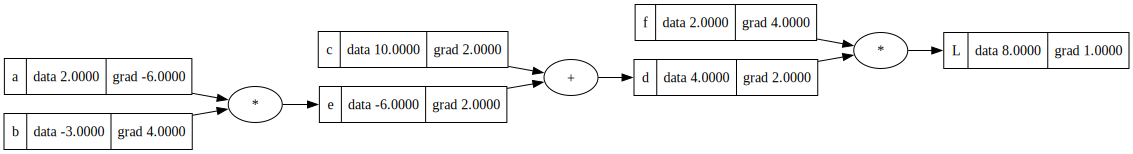

In [234]:
L.backward()

draw_dot(L)

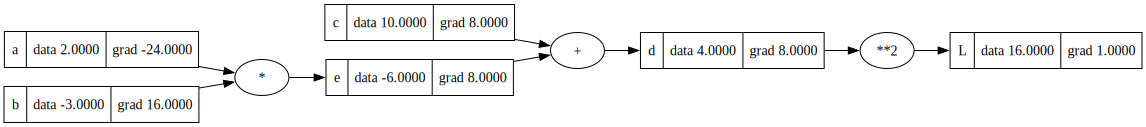

In [235]:
a=Value(2.0,label="a")
b=Value(-3.0,label="b")
c=Value(10.0,label="c")
e=a*b;e.label="e"   
d=e+c;d.label="d"
f=Value(2.0,label="f")
L=d**2;L.label="L"
L.backward()
draw_dot(L)

In [236]:
import random
class Module:
    """神经网络模块的基类"""

    def zero_grad(self):
        """将所有参数的梯度清零"""
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        """返回模块的所有参数，基类默认返回空列表"""
        return []

class Neuron(Module):
    """单个神经元类"""

    def __init__(self, nin, nonlin=True):
        """
        初始化神经元
        nin: 输入维度
        nonlin: 是否使用非线性激活函数(ReLU)
        """
        # 随机初始化权重
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # 偏置初始化为0
        self.b = Value(0)
        # 是否使用非线性激活
        self.nonlin = nonlin

    def __call__(self, x):
        """前向传播计算"""
        # 计算加权和加偏置
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        # 根据nonlin决定是否应用ReLU激活函数
        return act.relu() if self.nonlin else act

    def parameters(self):
        """返回神经元的所有参数(权重+偏置)"""
        return self.w + [self.b]

    def __repr__(self):
        """字符串表示"""
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    """神经网络层类，包含多个神经元"""

    def __init__(self, nin, nout, **kwargs):
        """
        初始化层
        nin: 输入维度
        nout: 输出维度(神经元数量)
        **kwargs: 传递给神经元的其他参数
        """
        # 创建nout个神经元
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        """前向传播"""
        # 每个神经元都处理相同的输入
        out = [n(x) for n in self.neurons]
        # 如果只有一个输出，直接返回值而不是列表
        return out[0] if len(out) == 1 else out

    def parameters(self):
        """返回层中所有神经元的参数"""
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        """字符串表示"""
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    """多层感知机(Multi-Layer Perceptron)"""

    def __init__(self, nin, nouts):
        """
        初始化MLP
        nin: 输入维度
        nouts: 各层的输出维度列表
        """
        # 构建层尺寸列表: [输入维度, 第一层输出, 第二层输出, ...]
        sz = [nin] + nouts
        # 创建各层，最后一层不使用非线性激活函数
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        """前向传播，逐层处理"""
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """返回所有层的参数"""
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        """字符串表示"""
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [237]:
# 创建一个单个神经元来测试
n = Neuron(2)  # 2个输入的神经元
print(f"神经元: {n}")
print(f"参数个数: {len(n.parameters())}")

# 测试前向传播
x = [2.0, 3.0]  # 输入值
out = n(x)
print(f"输入: {x}")
print(f"输出: {out}")
"""
    因为神经元有2个权重参数(对应2个输入)+ 1个偏置参数 = 3个参数总计。
    神经元的计算公式是:output = activation(w1*x1 + w2*x2 + b)，其中：
    w1, w2 是两个权重参数
    b 是偏置参数
    所以2个输入的神经元需要3个可训练参数。
"""
# 查看内部参数
print(f"权重: {[w.data for w in n.w]}")
print(f"偏置: {n.b.data}")


神经元: ReLUNeuron(2)
参数个数: 3
输入: [2.0, 3.0]
输出: Value(data=0,grad=0.0)
权重: [-0.942992365856236, 0.2511855173607318]
偏置: 0


In [238]:
"""
    这是一个输入维度为2,输出维度为3的单层。
    Layer(2, 3) 创建了一个包含3个神经元的层,每个神经元都接收2维输入并输出1维标量:
    输入: 2维向量 [2.0, 3.0] 
    输出: 3维向量(由3个神经元各自的1维标量输出组成)
    参数总数: 3个神经元 *(2个权重 + 1个偏置) = 9个参数
"""

l = Layer(2, 3)
print(f"层: {l}")
print(f"参数个数: {len(l.parameters())}")

# 测试前向传播
x = [2.0, 3.0]  # 输入值
out = l(x)
print(f"输入: {x}")
print(f"输出: {out}")
print(f"输出维度: {len(out)}")

层: Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
参数个数: 9
输入: [2.0, 3.0]
输出: [Value(data=0,grad=0.0), Value(data=0,grad=0.0), Value(data=0,grad=0.0)]
输出维度: 3


In [239]:
# 创建一个多层感知机 MLP(2, [3, 4, 5])
# 输入维度: 2
# 隐藏层结构: [3, 4, 5] 表示第一层3个神经元，第二层4个神经元，第三层5个神经元
# 
# 数据流向:
# 输入(2维) -> 第一层(3个神经元) -> 输出(3维) 
#           -> 第二层(4个神经元) -> 输出(4维)
#           -> 第三层(5个神经元) -> 输出(5维)

nn = MLP(2, [3, 4, 5])
print(f"多层感知机: {nn}")
print(f"总参数个数: {len(nn.parameters())}")

# 测试前向传播
x = [2.0, 3.0]  # 2维输入
out = nn(x)
print(f"输入: {x} (维度: {len(x)})")
print(f"最终输出: {out} (维度: {len(out)})")

# 参数计算说明:
# 第一层: 2个输入 -> 3个神经元, 每个神经元3个参数(2权重+1偏置) = 3*3 = 9个参数
# 第二层: 3个输入 -> 4个神经元, 每个神经元4个参数(3权重+1偏置) = 4*4 = 16个参数  
# 第三层: 4个输入 -> 5个神经元, 每个神经元5个参数(4权重+1偏置) = 5*5 = 25个参数
# 总计: 9 + 16 + 25 = 50个参数

多层感知机: MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [LinearNeuron(4), LinearNeuron(4), LinearNeuron(4), LinearNeuron(4), LinearNeuron(4)]]
总参数个数: 50
输入: [2.0, 3.0] (维度: 2)
最终输出: [Value(data=0.23988334231115432,grad=0.0), Value(data=0.5007853887847229,grad=0.0), Value(data=-1.0388603073363014,grad=0.0), Value(data=1.0528674275880519,grad=0.0), Value(data=0.9918608337874074,grad=0.0)] (维度: 5)


损失函数 (所有输出的和): Value(data=1.7465366851350352,grad=0.0)
反向传播完成


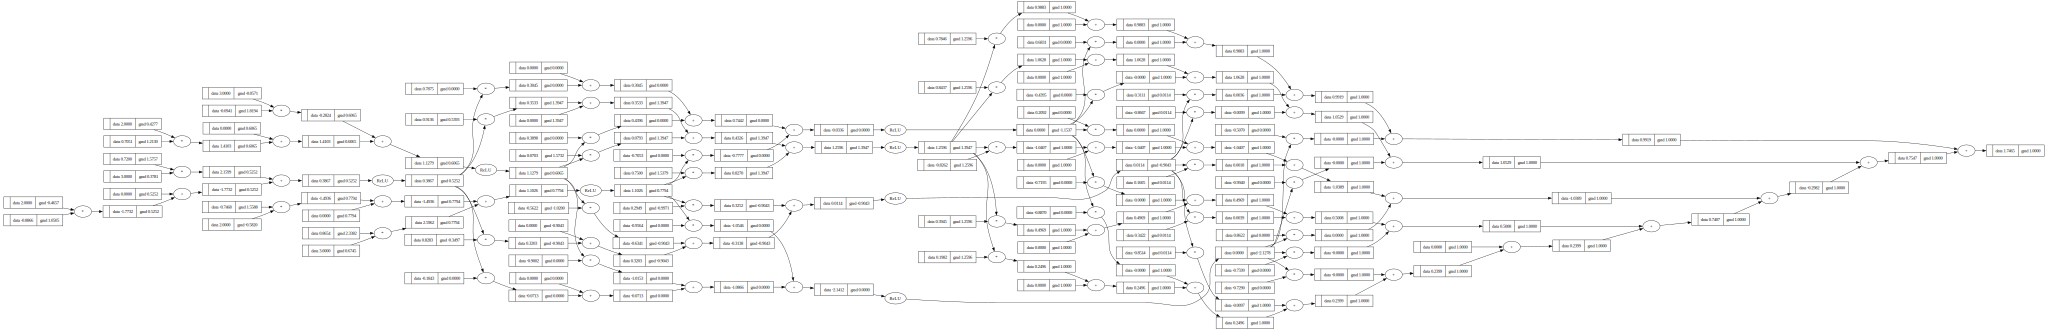

In [241]:
#计算所有输出的和，然后进行反向传播
#这样可以得到一个标量，就能调用 backward() 方法了

loss = sum(out)  # 将所有输出求和，得到一个单个 Value 对象
print(f"损失函数 (所有输出的和): {loss}")

loss.backward()  # 对标量进行反向传播
print("反向传播完成")

draw_dot(loss)  # 绘制计算图

In [243]:
#demo
import random
import numpy as np
import matplotlib.pyplot as plt


In [244]:
np.random.seed(1337)
random.seed(1337)

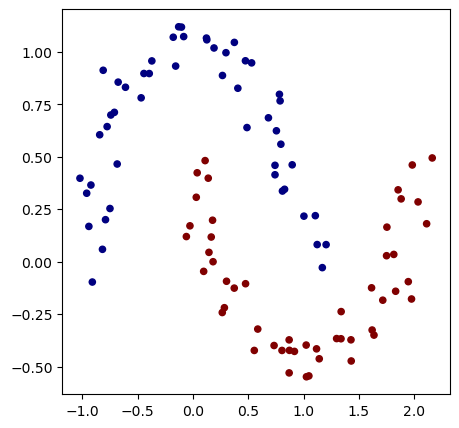

In [245]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [246]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [247]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.8958441028683222,grad=0.0) 0.5


In [248]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.7429006313851131, accuracy 77.0%
step 3 loss 0.7705641260584201, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.313545481918522, accuracy 86.0%
step 6 loss 0.2814234349772434, accuracy 89.0%
step 7 loss 0.26888733313983904, accuracy 91.0%
step 8 loss 0.2567147286057417, accuracy 91.0%
step 9 loss 0.2704862551637922, accuracy 91.0%
step 10 loss 0.24507023853658041, accuracy 91.0%
step 11 loss 0.2509905529791503, accuracy 92.0%
step 12 loss 0.21560951851922952, accuracy 91.0%
step 13 loss 0.2309037844640272, accuracy 93.0%
step 14 loss 0.20152151227899456, accuracy 92.0%
step 15 loss 0.2257450627928222, accuracy 93.0%
step 16 loss 0.19447987596204114, accuracy 92.0%
step 17 loss 0.21089496199246358, accuracy 93.0%
step 18 loss 0.15983077356303607, accuracy 94.0%
step 19 loss 0.18453748746883908, accuracy 93.0%
step 20 loss 0.18977522856087647, accuracy 

(-1.548639298268643, 1.951360701731357)

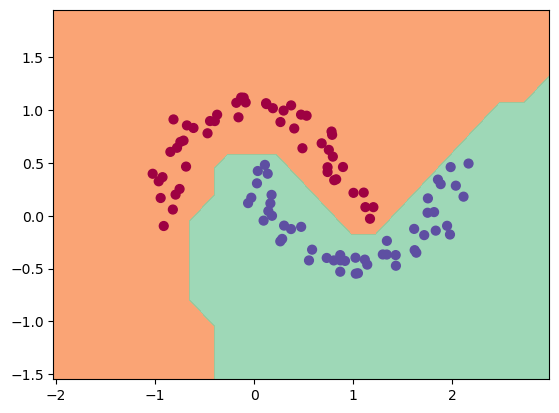

In [249]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())